### Examine the Data

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import statsmodels.api as sm

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [2]:

# Read the dataset
df_raw = pd.read_csv('stuckAt0_training.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'MS'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0.0,0.0,0
0.05,6.890000e-07,3.110000e-07,0,0.0,0.0,0.0,0
0.10,3.333928e-03,4.050000e-07,1,0.0,0.0,0.0,0
0.15,5.448433e-02,8.850002e-03,1,0.0,0.0,0.0,0
0.20,7.717051e-02,2.949715e-02,0,0.0,0.0,0.0,0


In [3]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
Tank3OutFlow       0
Tank2.level        0
wt3_valve          0
dtype: int64

### Plot the source data

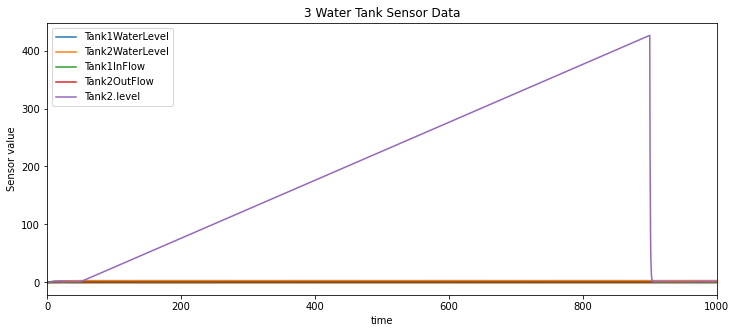

In [4]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [5]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [6]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.255233e+01
p-value                 2.192107e-23
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [7]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,Tank3OutFlow,Tank2.level,wt3_valve
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0.0,0.0,0
0.05,6.890000e-07,3.110000e-07,0,0.0,0.0,0.0,0
0.10,3.333928e-03,4.050000e-07,1,0.0,0.0,0.0,0
0.15,5.448433e-02,8.850002e-03,1,0.0,0.0,0.0,0
0.20,7.717051e-02,2.949715e-02,0,0.0,0.0,0.0,0


### Normalisation of the dataset

In [8]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [9]:
df = normalised_data

In [10]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### VAR Model Order Selection

In [11]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 43 has the least AIC value. Let us select p = 43 in the modelling


In [12]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [13]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1InFlow',
 'Tank1WaterLevel',
 'Tank2.level',
 'Tank2OutFlow',
 'Tank2WaterLevel',
 'Tank3OutFlow',
 'wt3_valve']

### Fit the VAR {{min_aic_index}}  model

In [14]:
min_aic_index

43

In [15]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jul, 2023
Time:                     10:43:40
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -79.0425
Nobs:                     16958.0    HQIC:                  -79.6890
Log likelihood:           512059.    FPE:                1.79194e-35
AIC:                     -80.0072    Det(Omega_mle):     1.58366e-35
--------------------------------------------------------------------
Results for equation Tank1InFlow
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.190097         0.007897          -24.073           0.000
L1.Tank1InFlow              0.031597         0.008730            3.619           0.000
L1.Tank1WaterLevel         -6.

### Predict the next 20 values

In [16]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

43

In [17]:
df.head()

,Tank1InFlow,Tank1WaterLevel,Tank2.level,Tank2OutFlow,Tank2WaterLevel,Tank3OutFlow,wt3_valve
time,,,,,,,
0.00,-1.001251,-13.751169,-4.102034,-11.718138,-13.647795,-0.563189,-0.58372
0.05,-1.001251,-13.751171,-4.102034,-11.718138,-13.647793,-0.563189,-0.58372
0.10,0.998751,-13.736104,-4.102034,-11.718138,-13.647793,-0.563189,-0.58372
0.15,0.998751,-13.504895,-4.102034,-11.718138,-13.607095,-0.563189,-0.58372
0.20,-1.001251,-13.402350,-4.102034,-11.718138,-13.512143,-0.563189,-0.58372


In [18]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 9.98239776e-01,  1.65432957e-01,  1.13218026e+03,
         1.26505933e-01,  1.23572776e-01, -5.62783409e-01,
        -5.87837465e-01],
       [ 9.97297150e-01,  2.70709832e-01,  1.13226550e+03,
         1.44200180e-01,  1.54667925e-01, -5.68575772e-01,
        -5.88418128e-01],
       [-1.00208630e+00,  1.75718708e-01,  1.13232310e+03,
         1.69784053e-01,  1.74578841e-01, -5.70310378e-01,
        -5.94020760e-01],
       [-1.00074162e+00,  5.75569668e-02,  1.13240954e+03,
         1.68286614e-01,  1.56492965e-01, -5.76835810e-01,
        -5.95808065e-01],
       [ 9.99788347e-01,  6.90195486e-02,  1.13246833e+03,
         1.43795480e-01,  1.29564988e-01, -5.77923203e-01,
        -5.99213064e-01],
       [ 1.00008389e+00,  2.04501131e-01,  1.13255520e+03,
         1.27328562e-01,  1.30113697e-01, -5.82138656e-01,
        -5.99125719e-01],
       [ 9.88176729e-01,  2.70572066e-01,  1.13261435e+03,
         1.44257298e-01,  1.54733181e-01, -5.81613207e-01,
        -6.0301699

In [19]:
test

,Tank1InFlow,Tank1WaterLevel,Tank2.level,Tank2OutFlow,Tank2WaterLevel,Tank3OutFlow,wt3_valve
time,,,,,,,
850.05,0.998751,0.165423,1132.180278,0.126510,0.123577,-0.563189,-0.583720
850.10,0.998751,0.270704,1132.265073,0.144185,0.154650,-0.563189,-0.583720
850.15,-1.001251,0.175745,1132.321676,0.169767,0.174565,-0.563189,-0.583720
850.20,-1.001251,0.057638,1132.406763,0.168293,0.156503,-0.563189,-0.583720
850.25,0.998751,0.068970,1132.463489,0.143823,0.129598,-0.563189,-0.583720
...,...,...,...,...,...,...,...
999.80,0.998751,0.165423,1.537017,0.126510,0.123577,-0.563189,-0.583720
999.85,0.998751,0.239056,1.593555,0.133595,0.140814,-0.563189,-0.583720
999.90,-1.001251,0.175745,1.678391,0.169767,0.174565,-0.563189,-0.583720


In [22]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.165537,0.123619,0.996819,0.126525,-0.588691,-0.548281,-0.247988
1,0.270788,0.154708,0.998383,0.144231,-0.609101,-0.505680,-0.173468
2,0.175628,0.174647,-1.001024,0.169848,-0.629707,-0.564651,-0.114193
3,0.057582,0.156509,-0.997674,0.168296,-0.652295,-0.568794,-0.032490
4,0.069364,0.129587,0.998347,0.143799,-0.667552,-0.661785,0.038323


### Plot the results

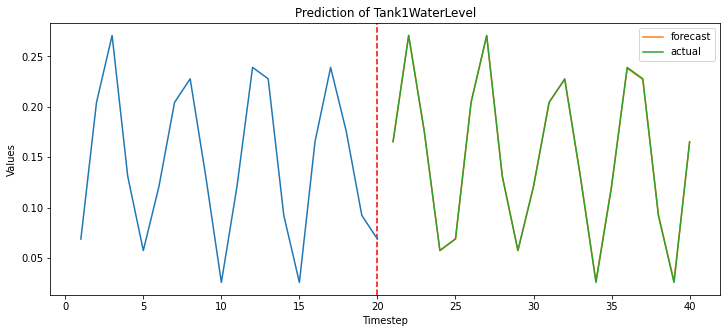

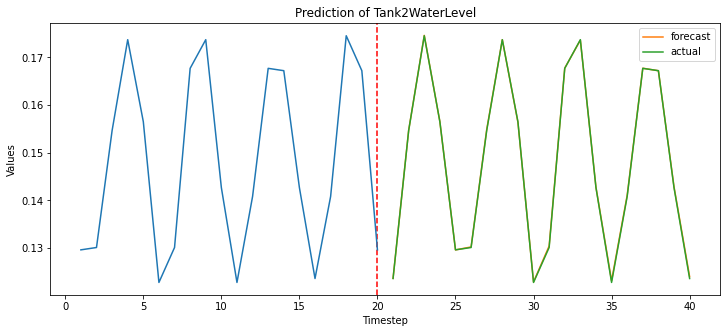

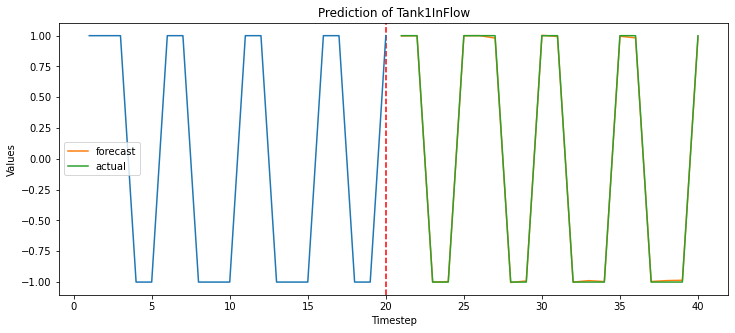

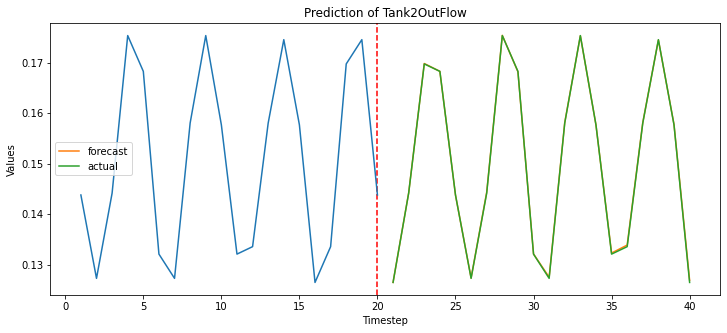

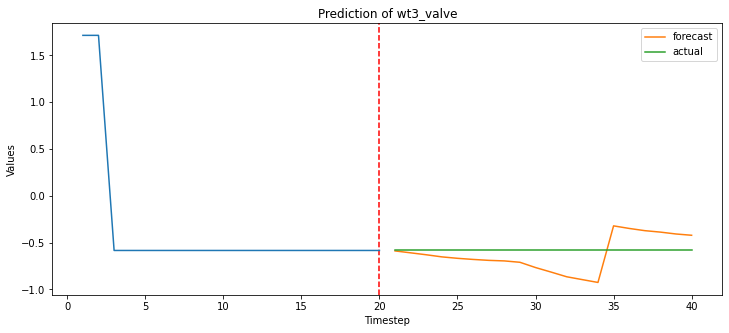

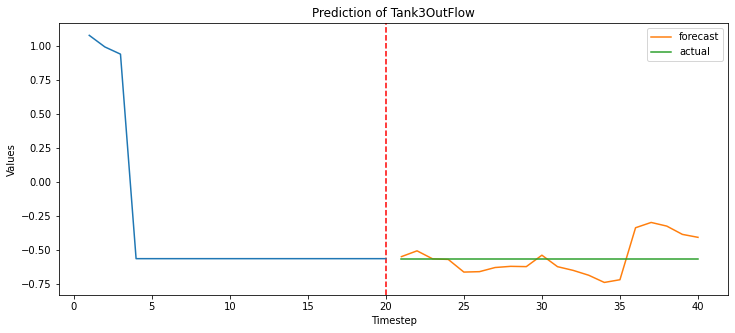

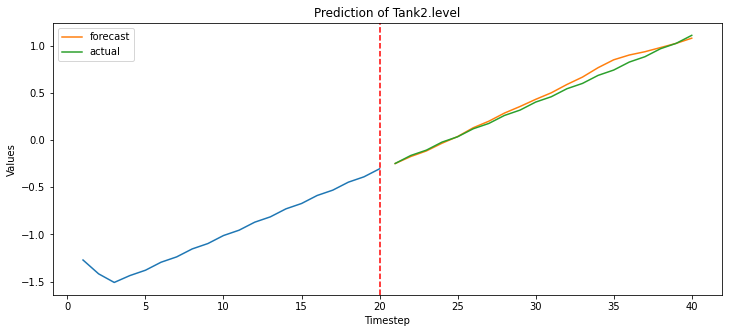

In [23]:
# attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(lag_order)))
#     actual = train.iloc[-lag_order:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    

    
attr = list(pd.read_csv('waterTank_ctrl_stuckAt0.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

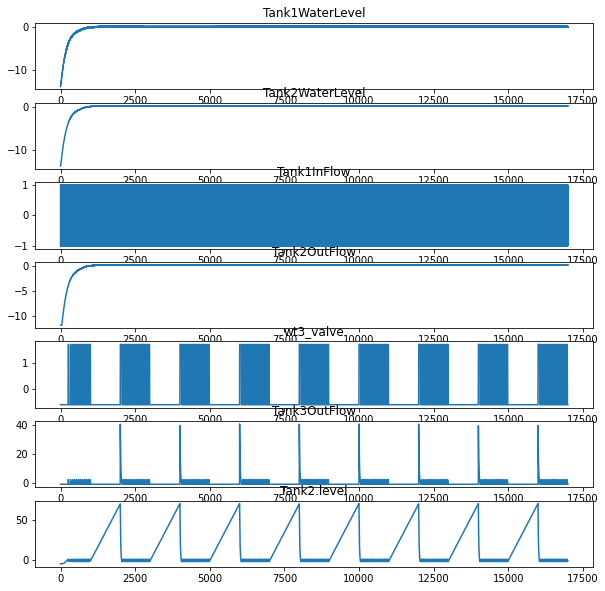

In [24]:
results.plot();

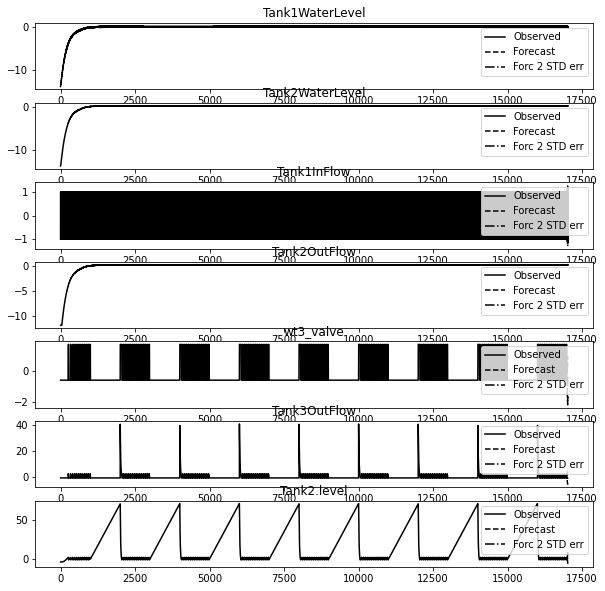

In [25]:
results.plot_forecast(20);

In [26]:
len(df_forecast)

20

In [27]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [28]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.0006359893848568923, 0.00017534935583204486, 0.008686195213453962, 0.00015699805802739858, 0.18803311794909838, 0.1323371194006024, 0.044841935069406126]


### Normalised RMSE

### Save the model

In [29]:
# Serialize andsave the model

with open('var_ctrl_stuckat0.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


In [30]:
print("Stop execution here")
print(error)

Stop execution here


NameError: name 'error' is not defined

### Define the faulty data

In [ ]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

### Load the model and reconstruct VAR

In [ ]:
with open('var_ctrl_stuckat0.pkl', 'rb') as f:
    params = pickle.load(f)
    
stuckat0_model = sm.tsa.VAR(train)
stuckat0_model.params = params
stuckat0_model_fit = stuckat0_model.fit(min_aic_index)

stuckat0_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = stuckat0_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = stuckat0_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)